In [1]:
!pip -q install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [1]:
# libraries
import os
import time
import subprocess
import numpy as np
import pandas as pd
import ast
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler
import albumentations
import torch.cuda.amp as amp
import segmentation_models_pytorch as smp
from tqdm import tqdm_notebook as tqdm

scaler = amp.GradScaler()
device = torch.device('cuda')

In [2]:
DEBUG = False
kernel_type = 'unet++b1_2cbce_1024T15tip_lr1e4_bs4_augv2_30epo'
enet_type = 'timm-efficientnet-b1'
data_dir = '../xray_image'
num_workers = 8
image_size = 512
batch_size = 4
init_lr = 1e-4
warmup_epo = 1
# If DEBUG == True, only run 3 epochs per fold
cosine_epo = 15 if not DEBUG else 2
n_epochs = warmup_epo + cosine_epo
use_amp = True
image_folder = 'train'

log_dir = 'logs'
model_dir = 'models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
log_file = os.path.join(log_dir, f'log_{kernel_type}.txt')

In [3]:
train_df = pd.read_csv(os.path.join(data_dir,'train.csv')).drop('PatientID', axis=1)
train_df.shape

(30083, 12)

In [4]:
train_df_annotations = pd.read_csv(os.path.join(data_dir,'train_annotations.csv'))
train_df_annotations.shape

(17999, 3)

In [5]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),                                    
    #albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightness(limit=0.1, p=0.75),
    albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, border_mode=0, p=0.75),
    albumentations.Cutout(max_h_size=int(image_size * 0.3), max_w_size=int(image_size * 0.3), num_holes=1, p=0.75),
])
transforms_val = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

In [6]:
class RANZCRDataset(Dataset):

    def __init__(self,df, mode, transform=None):

        self.df = df
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image = cv2.imread(os.path.join(data_dir, image_folder, self.df[index] + '.jpg'))[:, :, ::-1]
        
        if self.mode == 'test':
            mask = None
            res = self.transform(image=image)
        else:
            df_this = train_df_annotations.query(f'StudyInstanceUID == "{self.df[index]}"')
            mask = np.zeros((image.shape[0], image.shape[1], 1)).astype(np.uint8)
            for _, anno in df_this.iterrows():
                anno_this = np.array(ast.literal_eval(anno["data"]))
                mask1 = mask[:,:,0].copy()
                mask1 = cv2.polylines(mask1, np.int32([anno_this]), isClosed=False, color=1, thickness=15, lineType=16)
                mask[:, :, 0] = mask1
# #                 mask2 = mask[:, :, 1].copy()
#                 mask1 = cv2.circle(mask1, (anno_this[0][0], anno_this[0][1]), radius=15, color=1, thickness=25)
#                 mask1 = cv2.circle(mask1, (anno_this[-1][0], anno_this[-1][1]), radius=15, color=1, thickness=25)
#                 mask[:, :, 0] = mask1

            #mask = cv2.resize(mask ,(image_size, image_size))
            mask = (mask > 0.5).astype(np.uint8)
            res = self.transform(image=image, mask=mask)
            
        image = res['image'].astype(np.float32).transpose(2, 0, 1) / 255.

        if self.mode == 'test':
            return torch.tensor(image)
        else:
            mask = res['mask'].astype(np.float32)
            mask = mask.transpose(2, 0, 1).clip(0,1)
            return torch.tensor(image), torch.tensor(mask)

In [7]:
train_files = train_df_annotations['StudyInstanceUID'].unique()
len(train_files)

9095

In [8]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(8, 8))
    for i, (name, image) in enumerate(images.items()):
        if image.shape[0] == 3:
            image = image.numpy()
            image = image.transpose((1,2,0))
        elif image.shape[0] == 1:
            image = image.numpy()
            image = image.reshape(image.shape[1],image.shape[2])
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [9]:
dataset_show = RANZCRDataset(train_files,'train', transform=transforms_train)

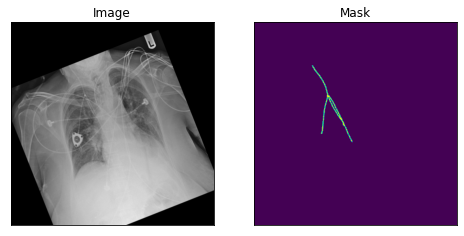

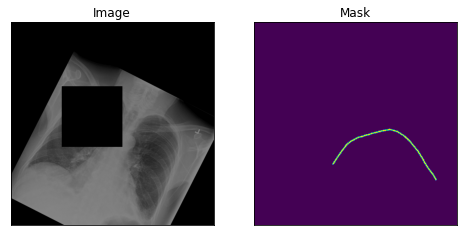

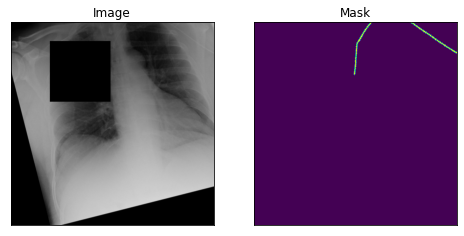

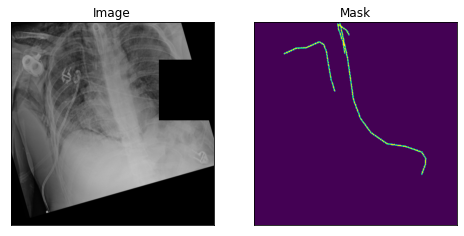

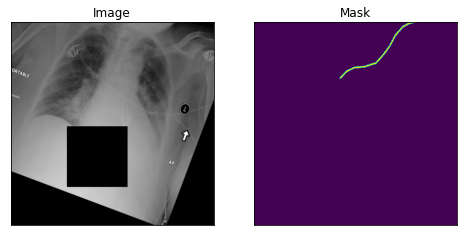

In [10]:
#visualizing some training data with augmentations implied
for i in range(5):
    image, mask = dataset_show[i]
    visualize(image=image, mask=mask)

In [11]:
class SegModel(nn.Module):
    def __init__(self, backbone):
        super(SegModel, self).__init__()
        self.seg = smp.UnetPlusPlus(encoder_name=backbone, encoder_weights='imagenet', classes=1, activation=None)
    def forward(self,x):
        global_features = self.seg.encoder(x)
        seg_features = self.seg.decoder(*global_features)
        seg_features = self.seg.segmentation_head(seg_features)
        return seg_features

m = SegModel(enet_type)
m(torch.rand(2,3,224,224)).shape

torch.Size([2, 1, 224, 224])

In [12]:
criterion = nn.BCEWithLogitsLoss()

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

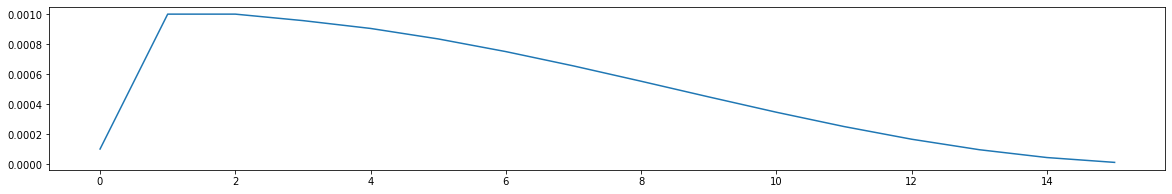

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

optimizer = optim.Adam(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_warmup.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
rcParams['figure.figsize'] = 20,3
plt.plot(lrs)

In [14]:
def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, mask) in bar:

        optimizer.zero_grad()
        data, mask = data.to(device), mask.to(device)

        with amp.autocast():
            logits = model(data)
            loss = criterion(logits, mask)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_np = loss.item()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-50:]) / min(len(train_loss), 50)
        bar.set_description('loss: %.4f, smth: %.4f' % (loss_np, smooth_loss))

    return np.mean(train_loss)

In [15]:
def valid_epoch(model, loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    with torch.no_grad():
        for (data, mask) in tqdm(loader):
            data, mask = data.to(device), mask.to(device)
            logits = model(data)
            loss = criterion(logits, mask)
            val_loss.append(loss.item())
            LOGITS.append(logits.cpu())

    if get_output:
        LOGITS = torch.cat(LOGITS, 0).float().sigmoid()
        return LOGITS
    else:
        val_loss = np.mean(val_loss)
        return val_loss

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_val = train_test_split(train_files,random_state = 42, test_size = 0.2)

In [17]:
print(len(X_train),len(X_val))

7276 1819


In [ ]:
content = ''
print(content)
with open(log_file, 'a') as appender:
    appender.write(content + '\n')

dataset_train = RANZCRDataset(X_train, 'train', transform=transforms_train)
dataset_valid = RANZCRDataset(X_val, 'valid', transform=transforms_val)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

model = SegModel(enet_type)
model = model.to(device)
val_loss_min = np.Inf


optimizer = optim.Adam(model.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler_warmup.step(epoch-1)

    train_loss = train_epoch(model, train_loader, optimizer)
    val_loss = valid_epoch(model, valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {(val_loss):.5f}.'
    print(content)
    with open(log_file, 'a') as appender:
        appender.write(content + '\n')

    if val_loss_min > val_loss:
        model_file = os.path.join(model_dir, f'{kernel_type}_best_epoch{epoch}.pth')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min, val_loss))
        torch.save(model.state_dict(), model_file)
        val_loss_min = val_loss


Mon Apr 26 14:57:46 2021 Epoch: 1


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

  0%|          | 0/1819 [00:00<?, ?it/s]